In [57]:
import ast
import copy
import gzip
import json
import os

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob

import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.width', 1000)  # Set display width
pd.set_option('display.max_colwidth', 100)  # Set max column width to 100 characters

# Review file preprocessing

Because json file is too big, and RAM memory can't support the whole json file, big json file is separated into smaller files, and all of them will be processed separately

In [ ]:
json_file_path = "Tools_and_Home_Improvement.json"
output_directory = "chunks_review"

# Create an output directory for chunks if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Read the input JSON file and write data in chunks
chunk = []
chunk_count = 0
with open(json_file_path, "r") as json_file:
    for line in json_file:
        # Parse each line as a JSON object
        data = json.loads(line)
        # Append the data to the chunk
        chunk.append(data)

        # Once chunk reaches 2,000,000 instances, save it and reset the chunk
        if len(chunk) >= 2000000:
            chunk_count += 1
            with open(os.path.join(output_directory, f"chunk_{chunk_count}.json"), "w") as chunk_file:
                json.dump(chunk, chunk_file, indent=4)
            chunk = []

    # Handle the last chunk which may be less than 2,000,000 instances
    if chunk:
        chunk_count += 1
        with open(os.path.join(output_directory, f"chunk_{chunk_count}.json"), "w") as chunk_file:
            json.dump(chunk, chunk_file, indent=4)

print(f"{chunk_count} chunk(s) saved in the '{output_directory}' directory.")


Reading of one chunk

In [ ]:
# Path to the chunk file
chunk_file_path = "chunks_review/chunk_1.json"

# Read the JSON file and load it into a DataFrame
with open(chunk_file_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head(3)

In [10]:
df_copy = df.copy(deep=True)

In [8]:
import pandas as pd

file_path = 'Tools_and_Home_Improvement.json'  # Update this with your file path

# Load only the first 10000 lines from the JSON file into a DataFrame
df = pd.read_json(file_path, lines=True, nrows=10000)

# Display the first few rows of the DataFrame
df.head()


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,3,True,"01 7, 2008",A11F6V4DD7WND4,0972970169,{'Format:': ' Misc. Supplies'},Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,1199664000,NaN,NaN
1,5,False,"03 8, 2007",AXPZYN4FP89L9,0972970169,{'Format:': ' Misc. Supplies'},Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,1173312000,NaN,NaN
2,4,False,"01 3, 2007",AOCT8ZWCRWLRE,0972970169,{'Format:': ' Misc. Supplies'},Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,1167782400,4,NaN
3,4,False,"06 20, 2006",A1UUD54HPAQZ2G,0972970169,{'Format:': ' Misc. Supplies'},K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,1150761600,11,NaN
4,4,False,"01 9, 2005",A2YHHBBJVTVD79,0972970169,{'Format:': ' Misc. Supplies'},Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,1105228800,25,NaN


In [9]:
# Get the shape and size of the dataset
print("Number of rows    :",df.shape[0])
print("Number of columns :",df.shape[1])

Number of rows    : 10000
Number of columns : 12


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2008-01-07 to 2005-10-05
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         10000 non-null  int64  
 1   verified        10000 non-null  bool   
 2   reviewerID      10000 non-null  object 
 3   asin            10000 non-null  object 
 4   style           7261 non-null   object 
 5   reviewerName    10000 non-null  object 
 6   reviewText      9999 non-null   object 
 7   summary         9997 non-null   object 
 8   unixReviewTime  10000 non-null  int64  
 9   vote            1295 non-null   float64
 10  image           73 non-null     object 
 11  sentiment       10000 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 947.3+ KB


In [10]:
# Find the number of missing values in each column
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style             2739
reviewerName         0
reviewText           1
summary              3
unixReviewTime       0
vote              8704
image             9927
dtype: int64


In [11]:
# Check the count of unique user and product data
unique_original = (df.reviewerID.nunique(), df.asin.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 9797
Count of unique Products : 88


Count of observations in each ratings:


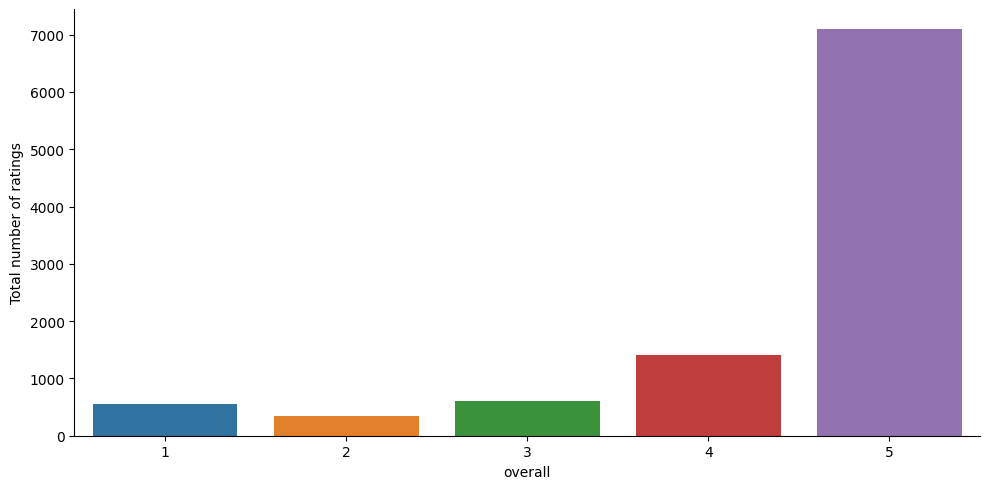

In [12]:
# Check the distribution of ratings 
print('Count of observations in each ratings:')
df.overall.value_counts()
g = sns.catplot(x="overall", data=df, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")

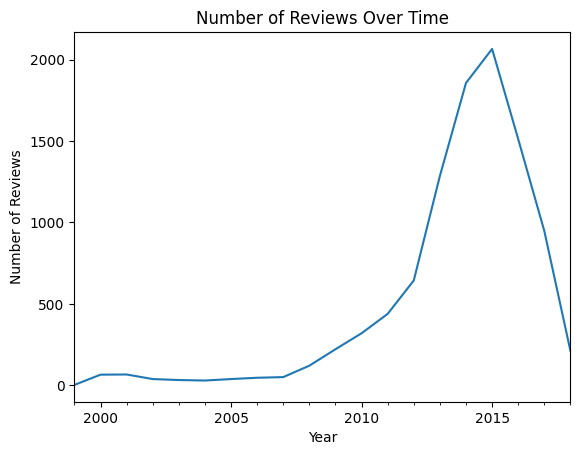

In [13]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df.set_index('reviewTime', inplace=True)
df.resample('Y').size().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()


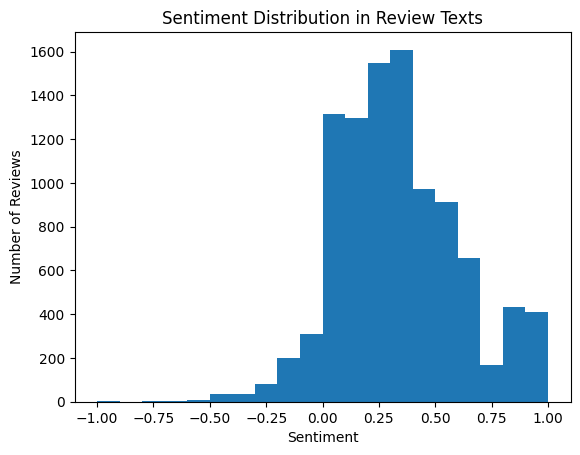

In [14]:
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply the function to review texts
df['sentiment'] = df['reviewText'].apply(calculate_sentiment)

# Plot sentiment distribution
df['sentiment'].hist(bins=20, grid=False)
plt.title('Sentiment Distribution in Review Texts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


In [15]:
df['vote'] = pd.to_numeric(df['vote'], errors='coerce')
correlation = df[['overall', 'vote']].corr()
print(correlation)


          overall      vote
overall  1.000000  0.031461
vote     0.031461  1.000000


In [30]:
product_review_counts = df.groupby('asin')['reviewerID'].count().sort_values(ascending=True)
print("Top 10 most unpopular products")
product_review_counts.head(10)


Top 10 most unpopular products


asin
7115138931    1
1590651529    1
7302094888    1
B000022314    2
B0000222UV    2
9178880661    2
7109074919    2
7223020318    3
1934047295    3
7806865365    3
Name: reviewerID, dtype: int64

Obviously, there are columns which are empty, so we are dropping them

In [16]:
columns_to_drop = ['vote', 'image', 'style']
df = df.drop(columns=columns_to_drop)
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,3,True,"01 7, 2008",A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,1199664000
1,5,False,"03 8, 2007",AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,1173312000
2,4,False,"01 3, 2007",AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,1167782400
3,4,False,"06 20, 2006",A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,1150761600
4,4,False,"01 9, 2005",A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,1105228800


In [18]:
# Drop rows where 'summary' is missing or NaN
df = df.dropna(subset=['summary'])

# Display the updated DataFrame
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,3,True,"01 7, 2008",A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,1199664000
1,5,False,"03 8, 2007",AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,1173312000
2,4,False,"01 3, 2007",AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,1167782400
3,4,False,"06 20, 2006",A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,1150761600
4,4,False,"01 9, 2005",A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,1105228800


In [17]:
# Drop rows where 'reviewerNae' or reviewText is missing or NaN
df = df.dropna(subset=['reviewerName', 'reviewText'])

# Display the updated DataFrame
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,3,True,"01 7, 2008",A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,1199664000
1,5,False,"03 8, 2007",AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,1173312000
2,4,False,"01 3, 2007",AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,1167782400
3,4,False,"06 20, 2006",A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,1150761600
4,4,False,"01 9, 2005",A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,1105228800


In [19]:
# Find the number of missing values in each column
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

overall           0
verified          0
reviewTime        0
reviewerID        0
asin              0
reviewerName      0
reviewText        0
summary           0
unixReviewTime    0
dtype: int64


Encoding of verified column, we are using label encoder

In [20]:
label_encoder = LabelEncoder()
df['verified'] = label_encoder.fit_transform(df['verified'])
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,3,1,"01 7, 2008",A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,1199664000
1,5,0,"03 8, 2007",AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,1173312000
2,4,0,"01 3, 2007",AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,1167782400
3,4,0,"06 20, 2006",A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,1150761600
4,4,0,"01 9, 2005",A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,1105228800


Date and time separating

In [21]:
# Convert 'reviewTime' column to datetime format
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y')
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,3,1,2008-01-07,A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,1199664000
1,5,0,2007-03-08,AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,1173312000
2,4,0,2007-01-03,AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,1167782400
3,4,0,2006-06-20,A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,1150761600
4,4,0,2005-01-09,A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,1105228800


We have two columns for time, 'UnixReviewTime' and 'ReviewTime', we don't need both

In [22]:
# Drop the 'unixReviewTime' column
df = df.drop(columns=['unixReviewTime'])
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,3,1,2008-01-07,A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge
1,5,0,2007-03-08,AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom
2,4,0,2007-01-03,AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light


Extract Year, Month, Day as separate columns


In [23]:
df['reviewTime_year'] = df['reviewTime'].dt.year
df['reviewTime_month'] = df['reviewTime'].dt.month
df['reviewTime_day'] = df['reviewTime'].dt.day

df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,reviewTime_year,reviewTime_month,reviewTime_day
0,3,1,2008-01-07,A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,2008,1,7
1,5,0,2007-03-08,AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,2007,3,8


Dropping column 'ReviewTime" because we extracted it

In [24]:
df = df.drop(columns=['reviewTime'])
df.head(5)

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,reviewTime_year,reviewTime_month,reviewTime_day
0,3,1,A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,2008,1,7
1,5,0,AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,2007,3,8
2,4,0,AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,2007,1,3
3,4,0,A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,2006,6,20
4,4,0,A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,2005,1,9


In [25]:
# Derive the number of reviews by each reviewer
df_review_count = df.groupby('reviewerID').size().reset_index(name='num_reviews')

# Derive the average rating given by the reviewer
df_avg_rating = df.groupby('reviewerID')['overall'].mean().reset_index(name='avg_rating')

# Merge the two derived dataframes on 'reviewerID' 
result_df = pd.merge(df_review_count, df_avg_rating, on='reviewerID')

sorted_result_df = result_df.sort_values(by='num_reviews', ascending=False)
print(sorted_result_df)

          reviewerID  num_reviews  avg_rating
8224    ADLVFFE4VBT8            6    4.166667
1595  A1LPYHZGTXWDX8            5    5.000000
1871  A1PUXF0PH4ZKA3            5    5.000000
2299   A1VQHH85U7PX0            4    5.000000
4906  A2VBM7X4LOEC3Z            4    1.000000
...              ...          ...         ...
3295  A29HKVDQLMDEOI            1    3.000000
3296  A29IFUPCOQJ74W            1    5.000000
3297  A29IP2N2DSBH3T            1    4.000000
3298  A29JVE2VDKR8IN            1    5.000000
9792   AZZDM6TV59VCW            1    5.000000

[9793 rows x 3 columns]


In [27]:
# Derive the number of reviews for each product
product_review_count = df.groupby('asin').size().reset_index(name='num_reviews')

# Derive the average rating for each product
product_avg_rating = df.groupby('asin')['overall'].mean().reset_index(name='avg_overall')

# Merge the two derived dataframes on 'asin'
result_df = pd.merge(product_review_count, product_avg_rating, on='asin')

sorted_result_df = result_df.sort_values(by='num_reviews', ascending=False)
print(sorted_result_df)

          asin  num_reviews  avg_overall
11  193362275X         3723     4.452055
31  7300025137         1226     4.414356
24  7109036146          544     4.529412
13  1940019532          385     4.036364
1   0982085028          275     4.690909
..         ...          ...          ...
83  B000022314            2     4.000000
56  B0000222UV            2     5.000000
33  7302094888            1     5.000000
28  7115138931            1     5.000000
3   1590651529            1     5.000000

[88 rows x 3 columns]


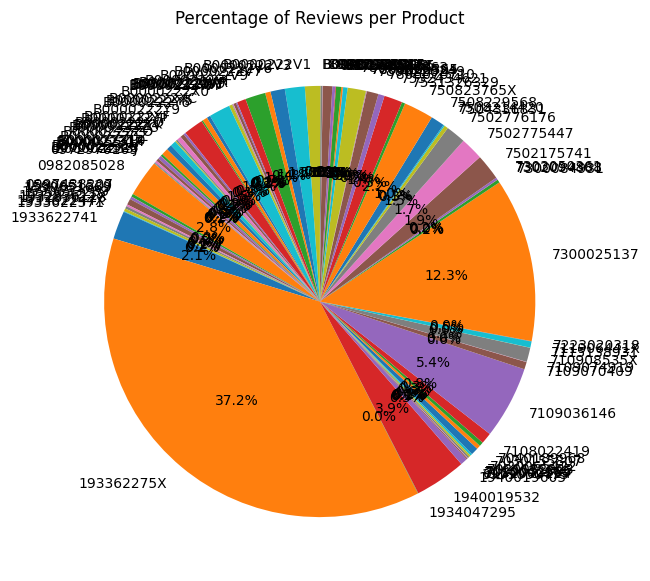

In [28]:
# Pita chart za sve proizvode
plt.figure(figsize=(10, 7))  # Podesi veličinu figure
plt.pie(result_df['num_reviews'], labels=result_df['asin'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Reviews per Product')
plt.show()


If we look at pie chart up, we can see that there are very popular products, that may not be good for neural network, but in further proceeding we will try to train with and without them

There, we are making new columns, number of reviews for every product and average rating

In [29]:
# Compute the number of reviews and average rating for each product
product_stats = df.groupby('asin').agg(
    num_reviews=('overall', 'size'),
    avg_overall=('overall', 'mean')
).reset_index()

# Merge the statistics back into the original dataframe on 'asin'
df = df.merge(product_stats, on='asin', how='left')

df.head(5)

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,reviewTime_year,reviewTime_month,reviewTime_day,num_reviews,avg_overall
0,3,1,A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,book lightwedge,2008,1,7,5,4.0
1,5,0,AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,Twins in bedroom,2007,3,8,5,4.0
2,4,0,AOCT8ZWCRWLRE,0972970169,Sarah Kile,I read in bed every night and I have tried almost every kind of book light out there. I have one...,Great little light,2007,1,3,5,4.0
3,4,0,A1UUD54HPAQZ2G,0972970169,K. H. Folsom Jr.,This little light saved my marriage. My wife awakens at the slightest light. I on the other ha...,Saved my marriage,2006,6,20,5,4.0
4,4,0,A2YHHBBJVTVD79,0972970169,Literatus,The first paperback lightwedge I purchased from Barnes and Noble as a present. When I tried it ...,Almost the best book light,2005,1,9,5,4.0


This preparation process transforms the textual data into a numerical format that can be effectively used in Graph Neural Networks. By tokenizing the text, generating word embeddings, and then averaging these embeddings, we are able to represent the text data as vectors that encapsulate the semantic meanings of the words. This is crucial for the success of machine learning models, especially GNNs, in processing and analyzing textual data.

In [30]:
# Tokenize the text
df['tokenized_summary'] = df['summary'].apply(word_tokenize)

# Train a Word2Vec model
model = Word2Vec(sentences=df['tokenized_summary'], vector_size=100, window=5, min_count=1, workers=4)
model.train(df['tokenized_summary'], total_examples=model.corpus_count, epochs=10)

# Function to average word vectors for a text
def get_vector(text):
    vec = []
    num = 0
    for word in text:
        try:
            vec.append(model.wv[word])
            num += 1
        except:
            continue
    return np.mean(vec, axis=0)

df['summary_embedding'] = df['tokenized_summary'].apply(get_vector)


c:\Users\Nikola Petrovic\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
df.drop(columns=['tokenized_summary', 'summary'], axis=1, inplace=True)
df.head(2)

In [36]:
# Tokenize the reviewText
df['tokenized_reviewText'] = df['reviewText'].apply(word_tokenize)

# Train a Word2Vec model on reviewText tokens
model = Word2Vec(sentences=df['tokenized_reviewText'], vector_size=100, window=5, min_count=1, workers=4)
model.train(df['tokenized_reviewText'], total_examples=model.corpus_count, epochs=10)
# Get the embeddings for reviewText

df['reviewText_embedding'] = df['tokenized_reviewText'].apply(get_vector)
df.head(2)

,overall,verified,reviewerID,asin,reviewerName,reviewText,reviewTime_year,reviewTime_month,reviewTime_day,num_reviews,avg_overall,summary_embedding,tokenized_reviewText,reviewText_embedding
0,3,1,A11F6V4DD7WND4,0972970169,Patti,I received the book lightwedge but have not used it as of yet so I cannot give a rating,2008,1,7,5,4.0,"[0.03523069, 0.11031662, 0.0314211, -0.04870499, 0.012789654, -0.25267738, 0.108048305, 0.545657...","[I, received, the, book, lightwedge, but, have, not, used, it, as, of, yet, so, I, can, not, giv...","[0.32878143, 0.5443114, -0.0144567955, -0.41948524, -0.1004955, -0.101737164, 0.60988843, 0.2369..."
1,5,0,AXPZYN4FP89L9,0972970169,Jonas Olson,And still can I read a book without disturbing their sleep (or mine...).,2007,3,8,5,4.0,"[-0.024518391, 0.22989917, 0.21586455, -0.205759, 0.047732506, -0.26487052, -0.005654587, 0.4717...","[And, still, can, I, read, a, book, without, disturbing, their, sleep, (, or, mine, ..., ), .]","[0.5308964, 0.13847339, -0.18013652, -0.79360974, -0.20535035, -0.38812095, 0.7510174, 0.1589700..."


In [37]:
df.drop('tokenized_reviewText', axis=1, inplace=True)
df.drop('reviewText', axis=1, inplace=True)
df.head(2)

,overall,verified,reviewerID,asin,reviewerName,reviewTime_year,reviewTime_month,reviewTime_day,num_reviews,avg_overall,summary_embedding,reviewText_embedding
0,3,1,A11F6V4DD7WND4,0972970169,Patti,2008,1,7,5,4.0,"[0.03523069, 0.11031662, 0.0314211, -0.04870499, 0.012789654, -0.25267738, 0.108048305, 0.545657...","[0.32878143, 0.5443114, -0.0144567955, -0.41948524, -0.1004955, -0.101737164, 0.60988843, 0.2369..."
1,5,0,AXPZYN4FP89L9,0972970169,Jonas Olson,2007,3,8,5,4.0,"[-0.024518391, 0.22989917, 0.21586455, -0.205759, 0.047732506, -0.26487052, -0.005654587, 0.4717...","[0.5308964, 0.13847339, -0.18013652, -0.79360974, -0.20535035, -0.38812095, 0.7510174, 0.1589700..."


In [38]:
# Tokenize the reviewerName
df['tokenized_reviewerName'] = df['reviewerName'].apply(lambda x: word_tokenize(str(x)))

# Train a Word2Vec model on reviewerName tokens
model = Word2Vec(sentences=df['tokenized_reviewerName'], vector_size=100, window=3, min_count=1, workers=4)
model.train(df['tokenized_reviewerName'], total_examples=model.corpus_count, epochs=10)
# Get the embeddings for reviewerName
df['reviewerName_embedding'] = df['tokenized_reviewerName'].apply(get_vector)
df.head(2)

,overall,verified,reviewerID,asin,reviewerName,reviewTime_year,reviewTime_month,reviewTime_day,num_reviews,avg_overall,summary_embedding,reviewText_embedding,tokenized_reviewerName,reviewerName_embedding
0,3,1,A11F6V4DD7WND4,0972970169,Patti,2008,1,7,5,4.0,"[0.03523069, 0.11031662, 0.0314211, -0.04870499, 0.012789654, -0.25267738, 0.108048305, 0.545657...","[0.32878143, 0.5443114, -0.0144567955, -0.41948524, -0.1004955, -0.101737164, 0.60988843, 0.2369...",[Patti],"[-0.008190265, -0.005267412, -0.0041470574, -0.00022117546, 0.0034758472, -0.00065248506, -0.008..."
1,5,0,AXPZYN4FP89L9,0972970169,Jonas Olson,2007,3,8,5,4.0,"[-0.024518391, 0.22989917, 0.21586455, -0.205759, 0.047732506, -0.26487052, -0.005654587, 0.4717...","[0.5308964, 0.13847339, -0.18013652, -0.79360974, -0.20535035, -0.38812095, 0.7510174, 0.1589700...","[Jonas, Olson]","[-0.007522195, -0.0001875076, 0.004928296, 0.00016226247, -0.0053279996, 0.001456046, 0.00290405..."


In [39]:
df.drop('tokenized_reviewerName', axis=1, inplace=True)
df.drop('reviewerName', axis=1, inplace=True)
df.head(2)

,overall,verified,reviewerID,asin,reviewTime_year,reviewTime_month,reviewTime_day,num_reviews,avg_overall,summary_embedding,reviewText_embedding,reviewerName_embedding
0,3,1,A11F6V4DD7WND4,0972970169,2008,1,7,5,4.0,"[0.03523069, 0.11031662, 0.0314211, -0.04870499, 0.012789654, -0.25267738, 0.108048305, 0.545657...","[0.32878143, 0.5443114, -0.0144567955, -0.41948524, -0.1004955, -0.101737164, 0.60988843, 0.2369...","[-0.008190265, -0.005267412, -0.0041470574, -0.00022117546, 0.0034758472, -0.00065248506, -0.008..."
1,5,0,AXPZYN4FP89L9,0972970169,2007,3,8,5,4.0,"[-0.024518391, 0.22989917, 0.21586455, -0.205759, 0.047732506, -0.26487052, -0.005654587, 0.4717...","[0.5308964, 0.13847339, -0.18013652, -0.79360974, -0.20535035, -0.38812095, 0.7510174, 0.1589700...","[-0.007522195, -0.0001875076, 0.004928296, 0.00016226247, -0.0053279996, 0.001456046, 0.00290405..."


Because there are some invalid summaries, we need to remove them, this step is crucial for ensuring data integrity. By removing or correcting inconsistencies in the dataset, we improve the reliability of any analysis or model training that follows.

In [40]:
# Create a mask where shape is not (100,)
invalid_shape_mask = df['summary_embedding'].apply(lambda x: x.shape != (100,))

# Filter rows with invalid shapes
invalid_rows = df[invalid_shape_mask]

print(invalid_rows)
# Create a mask where shape is not (100,)
invalid_shape_mask = df['summary_embedding'].apply(lambda x: x.shape != (100,))

# Get the number of invalid rows
num_invalid_rows = invalid_shape_mask.sum()

print(num_invalid_rows)

# Create a mask where shape is not (100,)
invalid_shape_mask = df['summary_embedding'].apply(lambda x: x.shape != (100,))

# Remove rows with invalid shapes
df = df[~invalid_shape_mask]  # Using "~" to negate the mask and keep only valid rows

      overall  verified      reviewerID        asin  reviewTime_year  reviewTime_month  reviewTime_day  num_reviews  avg_overall summary_embedding                                                                                 reviewText_embedding                                                                               reviewerName_embedding
3308        5         1  A3SVYEH8WJ7F4Z  193362275X             2013                 2              11         3723     4.452055               NaN  [-0.43023837, 0.123459905, 0.37237278, -1.2667395, -1.0034581, -1.1980081, 1.3269416, 0.60157937...  [0.0032765854, -0.0010152664, -0.00083337736, -0.0021025308, -0.0016789415, 0.0025325774, 0.0049...
1


# Metadata file preprocessing

Same story as review data, there are too much data and RAM can't keep it.

In [ ]:
json_file_path = "meta_Tools_and_Home_Improvement_metadata.json"
output_directory = "chunks"

# Create an output directory for chunks if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Read the input JSON file and write data in chunks
with gzip.open(json_file_path, "rt", encoding="utf-8") as json_file:
    chunk = []
    chunk_count = 0
    for line in json_file:
        # Parse each line as a JSON object
        data = json.loads(line)
        # Append the data to the chunk
        chunk.append(data)
        
        # Once chunk reaches 80,000 instances, save it and reset the chunk
        if len(chunk) >= 80000:
            chunk_count += 1
            with open(os.path.join(output_directory, f"chunk_{chunk_count}.json"), "w", encoding="utf-8") as chunk_file:
                json.dump(chunk, chunk_file, indent=4)
            chunk = []

    # Handle the last chunk which may be less than 80,000 instances
    if chunk:
        chunk_count += 1
        with open(os.path.join(output_directory, f"chunk_{chunk_count}.json"), "w", encoding="utf-8") as chunk_file:
            json.dump(chunk, chunk_file, indent=4)

print(f"{chunk_count} chunk(s) saved in the '{output_directory}' directory.")


We are reading one chunk

In [31]:
output_directory = "chunks"

# Path to the first chunk
chunk_file_path = os.path.join(output_directory, "chunk_8.json")

# Read the chunk and convert it into a DataFrame
with open(chunk_file_path, "r", encoding="utf-8") as file:
    chunk_data = json.load(file)
    df_metadata = pd.DataFrame(chunk_data)

# Display the first few rows to verify
df_metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,"[Tools & Home Improvement, Hardware, Door Hardware & Locks, Mail Slots]","class=""a-keyvalue prodDetTable"" role=""presentation"">\n \n \n \n ...","[Timeless design, great finishes and top quality brass construction make this our most popular s...",,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,[],,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...","[>#861,785 in Tools & Home Improvement (See top 100), >#186 in Tools & Home Improvement > Hardwa...","[B0051GHEO8, B016ATGMV0, B002YH3OP0, B074XFMBB8, B0781VHD2N, B01MZGS2KW, B005TTTT4U, B00EVDCT7E,...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spacing-extra-large a-size-base comparison_table"">\n\...","January 4, 2019",$1.94,B01FOD3PG8,[],[]
1,"[Tools & Home Improvement, Lighting & Ceiling Fans, Lamps & Shades, Table Lamps]","class=""a-keyvalue prodDetTable"" role=""presentation"">\n \n \n \n ...",[],,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,"[B00CO2S7JS, B00XQ9A5QG, B0775RRFG6]",,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,"[>#263,461 in Tools & Home Improvement (See top 100), >#2,066 in Tools & Home Improvement > Ligh...","[B00FLVOZQI, B00K8DWK9S, B00BJ7CZ2Y, B00K8DWT9O, B0058DSZOW, B00OV7SRE4, B00K8DVY6I, B074PV1GJM,...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spacing-extra-large a-size-base comparison_table"">\n\...","April 25, 2017",$3.92,B01FOBSK60,"[https://images-na.ssl-images-amazon.com/images/I/41WIMzNYQML._SX38_SY50_CR,0,0,38,50_.jpg, http...","[https://images-na.ssl-images-amazon.com/images/I/41WIMzNYQML.jpg, https://images-na.ssl-images-..."
2,"[Tools & Home Improvement, Kitchen & Bath Fixtures, Bathroom Fixtures, Bathroom Sink & Bathtub A...","class=""a-keyvalue prodDetTable"" role=""presentation"">\n \n \n \n ...",[Fits all standard bathroom sinks new and improved drain assembly installs in under five minutes...,,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",[],,Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...","[>#863,042 in Tools & Home Improvement (See top 100), >#534 in Tools & Home Improvement > Kitche...",[],{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spacing-extra-large a-size-base comparison_table"">\n\...","May 14, 2016",$10.71,B01FOASHFU,[],[]


In [32]:
# Get the shape and size of the dataset
print("Number of rows    :",df_metadata.shape[0])
print("Number of columns :",df_metadata.shape[1])

Number of rows    : 11535
Number of columns : 19


In [34]:
empty_count = df_metadata.applymap(lambda x: x == '' or x == [] or x == {}).sum()
print(empty_count)

category            1160
tech1               2709
description         2218
fit                11524
title                  1
also_buy            7630
tech2              11535
brand                563
feature             1914
rank                 210
also_view           7880
details            10838
main_cat              19
similar_item        6400
date                2453
price               5143
asin                   0
imageURL            2418
imageURLHighRes     2418
dtype: int64


Removing columns that are not helpfull or are not complete

In [35]:
# List of columns you want to drop
columns_to_drop = ['date', 'imageURL', 'imageURLHighRes', 'similar_item','category', 'tech1', 'fit', 'tech2', 'rank', 'details']  
# Drop the columns
df_metadata = df_metadata.drop(columns=columns_to_drop)

df_metadata.head(3)  # Display the first few rows to check

,description,title,also_buy,brand,feature,also_view,main_cat,price,asin
0,"[Timeless design, great finishes and top quality brass construction make this our most popular s...",Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,[],IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...","[B0051GHEO8, B016ATGMV0, B002YH3OP0, B074XFMBB8, B0781VHD2N, B01MZGS2KW, B005TTTT4U, B00EVDCT7E,...",Tools & Home Improvement,$1.94,B01FOD3PG8
1,[],Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,"[B00CO2S7JS, B00XQ9A5QG, B0775RRFG6]",360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,"[B00FLVOZQI, B00K8DWK9S, B00BJ7CZ2Y, B00K8DWT9O, B0058DSZOW, B00OV7SRE4, B00K8DVY6I, B074PV1GJM,...",Tools & Home Improvement,$3.92,B01FOBSK60
2,[Fits all standard bathroom sinks new and improved drain assembly installs in under five minutes...,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",[],Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",[],Tools & Home Improvement,$10.71,B01FOASHFU


Dropping also_buy and also_view columns, there are plans for this columns because they are interactions, with making them with Item2Vec for recommendation but there are much empty rows, so it will affect bad on recommendations

In [36]:
# List of columns you want to drop
columns_to_drop = ['also_buy', 'also_view']  # replace with your actual column names

# Drop the columns
df_metadata = df_metadata.drop(columns=columns_to_drop)

df_metadata.head(3)

,description,title,brand,feature,main_cat,price,asin
0,"[Timeless design, great finishes and top quality brass construction make this our most popular s...",Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,$1.94,B01FOD3PG8
1,[],Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,$3.92,B01FOBSK60
2,[Fits all standard bathroom sinks new and improved drain assembly installs in under five minutes...,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,$10.71,B01FOASHFU


Because there is not enough full rows for feature, and 'feature' and 'description' columns are giving the same info, we are filling empty features with descriptions

In [40]:
mask = df_metadata['feature'].apply(lambda x: x == [])
df_metadata.loc[mask, 'feature'] = df_metadata.loc[mask, 'description']

df_metadata.head(3)

,description,title,brand,feature,main_cat,price,asin
0,"[Timeless design, great finishes and top quality brass construction make this our most popular s...",Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,$1.94,B01FOD3PG8
1,[],Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,$3.92,B01FOBSK60
2,[Fits all standard bathroom sinks new and improved drain assembly installs in under five minutes...,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,$10.71,B01FOASHFU


In [41]:
columns_to_drop = ['description']  # replace with your actual column names

# Drop the columns
df_metadata = df_metadata.drop(columns=columns_to_drop)

df_metadata.head(3)

,title,brand,feature,main_cat,price,asin
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,$1.94,B01FOD3PG8
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,$3.92,B01FOBSK60
2,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,$10.71,B01FOASHFU


Filter out rows where 'brand' column is empty or NaN

In [42]:

df_metadata = df_metadata[df_metadata['brand'].notna() & (df_metadata['brand'] != '')]
df_metadata.head(3)

,title,brand,feature,main_cat,price,asin
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,$1.94,B01FOD3PG8
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,$3.92,B01FOBSK60
2,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,$10.71,B01FOASHFU


Fulfilling feature column 

In [43]:
df_metadata = df_metadata[df_metadata['feature'].astype(bool)]
df_metadata.head(3)

,title,brand,feature,main_cat,price,asin
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,$1.94,B01FOD3PG8
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,$3.92,B01FOBSK60
2,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,$10.71,B01FOASHFU


Define a function to check if a value is a valid price. Filter out invalid price strings. Only convert valid price entries to float. For invalid prices, set to NaN.

In [44]:
def is_valid_price(x):
    try:
        float(x.replace('$', '').replace(',', ''))
        return True
    except:
        return False

# Filter out invalid price strings
valid_prices = df_metadata['price'].str.replace('$', '').str.replace(',', '').apply(is_valid_price)

# Only convert valid price entries to float
df_metadata.loc[valid_prices, 'price'] = df_metadata.loc[valid_prices, 'price'].str.replace('$', '').str.replace(',', '').astype(float)

# For invalid prices, set to NaN 
df_metadata.loc[~valid_prices, 'price'] = np.nan

C:\Users\Nikola Petrovic\AppData\Local\Temp\ipykernel_15212\3214444637.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  valid_prices = df_metadata['price'].str.replace('$', '').str.replace(',', '').apply(is_valid_price)
C:\Users\Nikola Petrovic\AppData\Local\Temp\ipykernel_15212\3214444637.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_metadata.loc[valid_prices, 'price'] = df_metadata.loc[valid_prices, 'price'].str.replace('$', '').str.replace(',', '').astype(float)


In [45]:
df_metadata.head(3)

,title,brand,feature,main_cat,price,asin
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,1.94,B01FOD3PG8
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,3.92,B01FOBSK60
2,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,10.71,B01FOASHFU


Compute average price for each main_cat based on the non-missing prices. Fill in only the missing prices with the average price from the same main_cat

In [46]:
avg_prices = df_metadata.groupby('main_cat')['price'].mean()

df_metadata['price'] = df_metadata.apply(
    lambda row: avg_prices[row['main_cat']] if pd.isnull(row['price']) else row['price'], 
    axis=1
)
df_metadata['price'] = df_metadata['price'].round(2)
df_metadata.head()

,title,brand,feature,main_cat,price,asin
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,1.94,B01FOD3PG8
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,3.92,B01FOBSK60
2,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,10.71,B01FOASHFU
3,Electrolux 5303918214 Thermostat-Defrost,Electrolux,"[This is an O.E.M. Authorized part, Fits with various Electrolux brand models, Oem part # 530391...",Tools & Home Improvement,1.94,B01FOFBHHK
4,LED Military USB Rechargeable Flashlight IP65 Waterproof Zoomable Tactical Torch Super Bright 90...,Goreit,[ULTRA BRIGHT: 900-lumen (max) Cree LED sweeps bright light over the length of about two footbal...,Tools & Home Improvement,18.99,B01FOFEVM8


Replace empty strings in the 'main_cat' column with 'Non Categorised'. Display the first few rows to verify


In [47]:
df_metadata['main_cat'] = df_metadata['main_cat'].replace('', 'Non Categorised')

df_metadata.head(2)

,title,brand,feature,main_cat,price,asin
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,1.94,B01FOD3PG8
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,3.92,B01FOBSK60


In [48]:
df_metadata = df_metadata[df_metadata['title'].str.strip() != '']


In [49]:
empty_count = df_metadata.applymap(lambda x: x == '' or x == []).sum()
print(empty_count)

title       0
brand       0
feature     0
main_cat    0
price       0
asin        0
dtype: int64


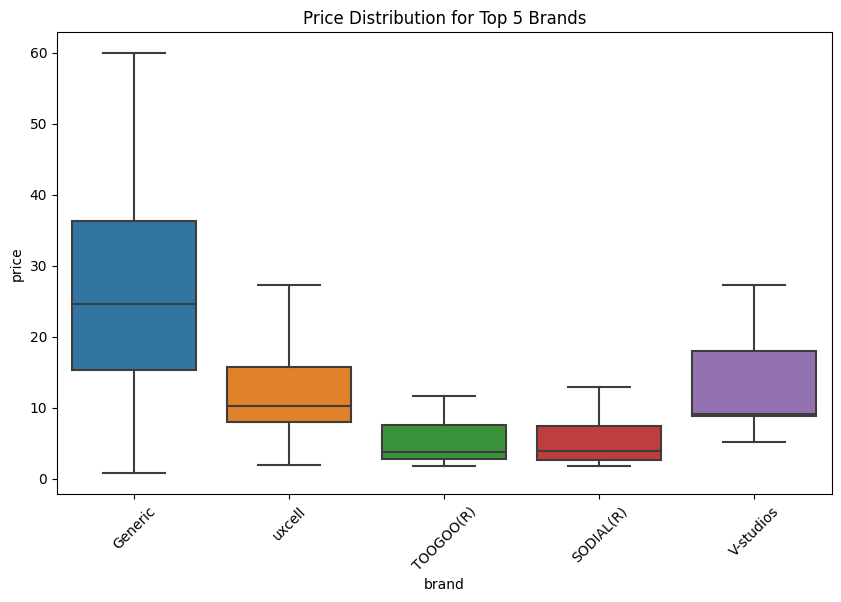

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_metadata is already loaded with your data

# Identifying the top 5 most popular brands
top_5_brands = df_metadata['brand'].value_counts().head(5).index

# Filtering the dataset for only the top 5 brands
top_brands_data = df_metadata[df_metadata['brand'].isin(top_5_brands)]

# Price Distribution Analysis for Top 5 Brands without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='brand', y='price', data=top_brands_data, showfliers=False)
plt.title('Price Distribution for Top 5 Brands')
plt.xticks(rotation=45)
plt.show()


c:\Users\Nikola Petrovic\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


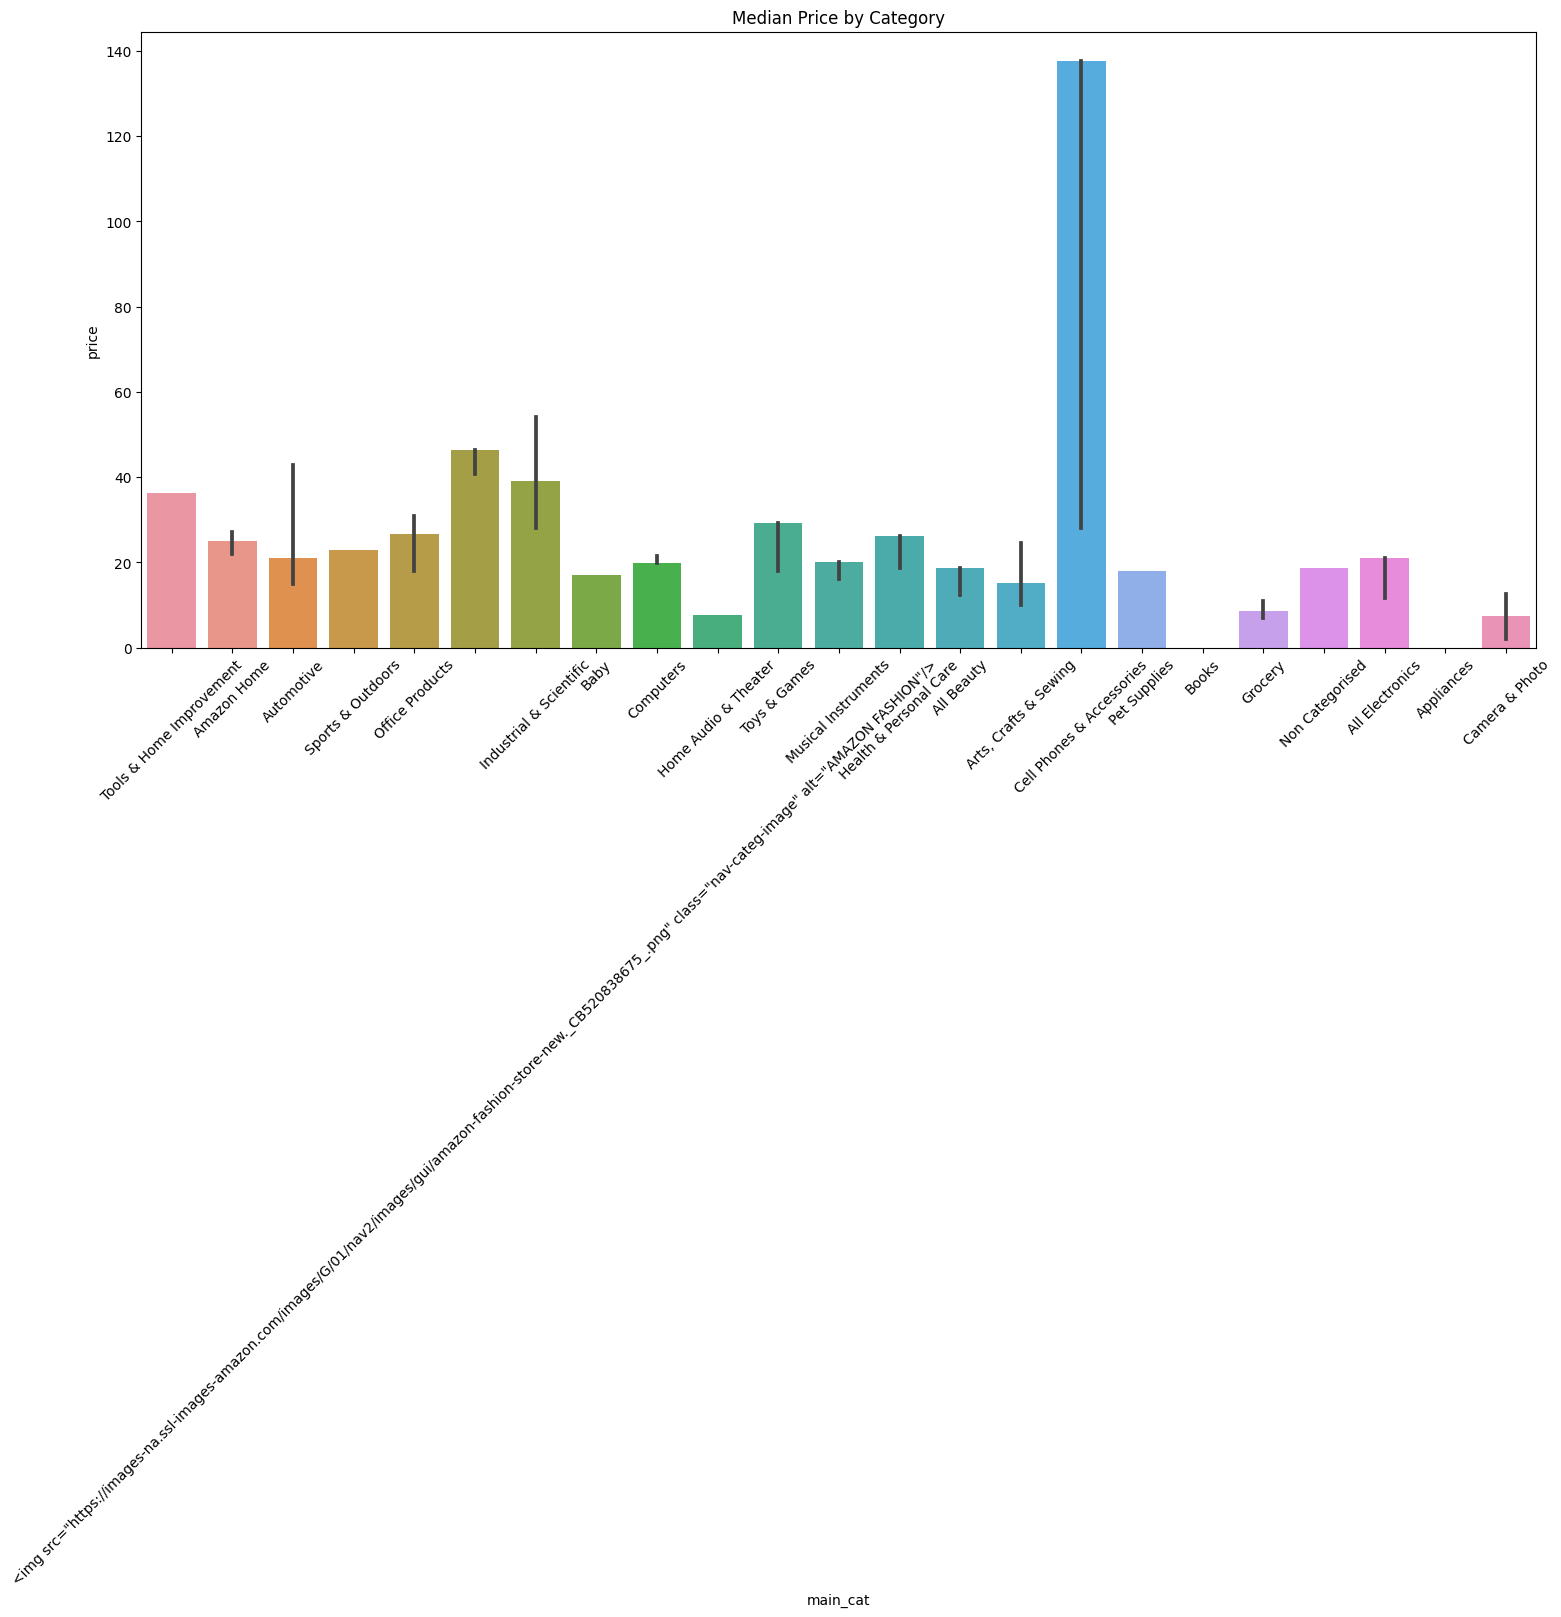

In [61]:
#Category-wise Price Analysis
plt.figure(figsize=(18, 8))
sns.barplot(x='main_cat', y='price', data=df_metadata, estimator=lambda x: np.median(x))
plt.title('Median Price by Category')
plt.xticks(rotation=45)
plt.show()

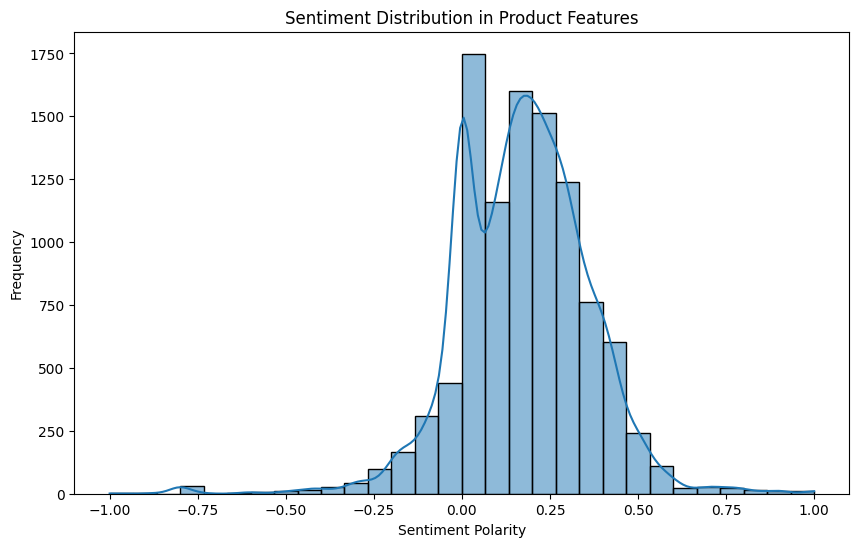

In [56]:
# Function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply the function to the 'feature' column
df_metadata['sentiment'] = df_metadata['feature'].apply(calculate_sentiment)

# Visualizing the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_metadata['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution in Product Features')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


Vectorization

In [56]:
# Function to average word vectors for a text
def get_vector(text):
    vec = []
    num = 0
    for word in text:
        try:
            vec.append(model.wv[word])
            num += 1
        except:
            continue
    return np.mean(vec, axis=0)

In [57]:

df_metadata['feature_str'] = df_metadata['feature'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Columns to tokenize and get embeddings
columns_to_embed = ['title', 'brand', 'main_cat', 'feature_str']

for column in columns_to_embed:
    # 2. Tokenize the content
    df_metadata[f'{column}_tokenized'] = df_metadata[column].apply(lambda x: word_tokenize(str(x)))
    
    # Train a Word2Vec model for this column
    model = Word2Vec(sentences=df_metadata[f'{column}_tokenized'], vector_size=100, window=5, min_count=1, workers=4)
    model.train(df_metadata[f'{column}_tokenized'], total_examples=model.corpus_count, epochs=10)

    # 3. Create a new column with the average embeddings
    df_metadata[f'{column}_embedding'] = df_metadata[f'{column}_tokenized'].apply(get_vector)


In [58]:
df_metadata.head(3)

,title,brand,feature,main_cat,price,asin,feature_str,title_tokenized,title_embedding,brand_tokenized,brand_embedding,main_cat_tokenized,main_cat_embedding,feature_str_tokenized,feature_str_embedding
0,Solid Brass Letter Size Mail Slot With Open Back Plate in Antique Brass,IDH by St. Simons,"[Solid-Brass Construction for Durability, Available in 5 Finishes Including PVD Lifetime, Authen...",Tools & Home Improvement,1.94,B01FOD3PG8,Solid-Brass Construction for Durability Available in 5 Finishes Including PVD Lifetime Authentic...,"[Solid, Brass, Letter, Size, Mail, Slot, With, Open, Back, Plate, in, Antique, Brass]","[-0.9921781, 0.17185117, 0.31034502, -0.053865295, 0.4419937, -0.87737817, 0.2402262, 0.9273665,...","[IDH, by, St., Simons]","[-0.0034941304, 0.005707793, -0.0029161104, -0.000762, 0.005399071, -0.035023566, -0.012122216, ...","[Tools, &, Home, Improvement]","[-0.09605328, 0.13511288, 0.024353098, 0.10977504, 0.12583356, -0.10256021, -0.045893088, 0.2308...","[Solid-Brass, Construction, for, Durability, Available, in, 5, Finishes, Including, PVD, Lifetim...","[-0.16374987, -0.112800665, 0.4182995, 0.1792441, 0.34141585, -0.18056883, 0.059733417, 0.763017..."
1,Camden Blue and White Stripe 19&quot; Ceramic Table Lamp Set of 2,360 Lighting,[Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; ac...,Tools & Home Improvement,3.92,B01FOBSK60,Set of 2 lamps: each is 19&quot; high overall. Shades are 10&quot; across the top x 12&quot; acr...,"[Camden, Blue, and, White, Stripe, 19, &, quot, ;, Ceramic, Table, Lamp, Set, of, 2]","[-0.17248198, 0.517851, -0.09021504, 0.13743542, -0.2552755, -1.3493637, 0.75167346, 1.2745408, ...","[360, Lighting]","[-0.014899755, 0.010162672, 0.018385848, 0.01669804, 0.01212873, -0.03690618, -0.017930359, 0.02...","[Tools, &, Home, Improvement]","[-0.09605328, 0.13511288, 0.024353098, 0.10977504, 0.12583356, -0.10256021, -0.045893088, 0.2308...","[Set, of, 2, lamps, :, each, is, 19, &, quot, ;, high, overall, ., Shades, are, 10, &, quot, ;, ...","[-0.19490343, 0.391797, -0.17940289, 0.42792246, -0.30239457, -1.1181675, 0.26146844, -0.0388290..."
2,"Ultra Faucets UFP-0501 Pop Up Drain Assembly with Overflow, Oil Rubbed Bronze Finish",Ultra,"[Metal body with non-metallic spring mechanism, With overflow, Rigorously tested to ensure quali...",Tools & Home Improvement,10.71,B01FOASHFU,Metal body with non-metallic spring mechanism With overflow Rigorously tested to ensure quality ...,"[Ultra, Faucets, UFP-0501, Pop, Up, Drain, Assembly, with, Overflow, ,, Oil, Rubbed, Bronze, Fin...","[-0.73042303, 0.5336159, -0.2495638, -0.037948277, 0.23416893, -1.0651939, 0.3015514, 1.2762655,...",[Ultra],"[-0.0018287195, -0.0053685065, 0.008541634, 0.003769354, 0.0023392239, 0.0039553484, -0.01137149...","[Tools, &, Home, Improvement]","[-0.09605328, 0.13511288, 0.024353098, 0.10977504, 0.12583356, -0.10256021, -0.045893088, 0.2308...","[Metal, body, with, non-metallic, spring, mechanism, With, overflow, Rigorously, tested, to, ens...","[-0.020707276, 0.36200187, 0.17411736, 0.07346503, 0.6612414, 0.018050104, 0.8013639, 0.2634872,..."


In [59]:
df_metadata = df_metadata.drop(columns=['title', 'brand', 'main_cat', 'feature_str', 'feature'])
df_metadata = df_metadata.drop(columns=['title_tokenized', 'brand_tokenized', 'main_cat_tokenized', 'feature_str_tokenized'])
df_metadata.head(3)

,price,asin,title_embedding,brand_embedding,main_cat_embedding,feature_str_embedding
0,1.94,B01FOD3PG8,"[-0.9921781, 0.17185117, 0.31034502, -0.053865295, 0.4419937, -0.87737817, 0.2402262, 0.9273665,...","[-0.0034941304, 0.005707793, -0.0029161104, -0.000762, 0.005399071, -0.035023566, -0.012122216, ...","[-0.09605328, 0.13511288, 0.024353098, 0.10977504, 0.12583356, -0.10256021, -0.045893088, 0.2308...","[-0.16374987, -0.112800665, 0.4182995, 0.1792441, 0.34141585, -0.18056883, 0.059733417, 0.763017..."
1,3.92,B01FOBSK60,"[-0.17248198, 0.517851, -0.09021504, 0.13743542, -0.2552755, -1.3493637, 0.75167346, 1.2745408, ...","[-0.014899755, 0.010162672, 0.018385848, 0.01669804, 0.01212873, -0.03690618, -0.017930359, 0.02...","[-0.09605328, 0.13511288, 0.024353098, 0.10977504, 0.12583356, -0.10256021, -0.045893088, 0.2308...","[-0.19490343, 0.391797, -0.17940289, 0.42792246, -0.30239457, -1.1181675, 0.26146844, -0.0388290..."
2,10.71,B01FOASHFU,"[-0.73042303, 0.5336159, -0.2495638, -0.037948277, 0.23416893, -1.0651939, 0.3015514, 1.2762655,...","[-0.0018287195, -0.0053685065, 0.008541634, 0.003769354, 0.0023392239, 0.0039553484, -0.01137149...","[-0.09605328, 0.13511288, 0.024353098, 0.10977504, 0.12583356, -0.10256021, -0.045893088, 0.2308...","[-0.020707276, 0.36200187, 0.17411736, 0.07346503, 0.6612414, 0.018050104, 0.8013639, 0.2634872,..."


In [60]:
problematic_rows = []

# Loop through the columns and identify rows with non-iterable entries
for col in ['title_embedding', 'brand_embedding', 'main_cat_embedding', 'feature_str_embedding']:
    for idx, value in df_metadata[col].iteritems():
        if not hasattr(value, '__iter__') or isinstance(value, (str, bytes)):
            problematic_rows.append(idx)

# Remove duplicate row indices and sort them
problematic_rows = sorted(set(problematic_rows))

# Display problematic rows
print(f"Number of problematic rows: {len(problematic_rows)}")
print("Indices of problematic rows:", problematic_rows)

# If you want to inspect the problematic rows in detail
print(df_metadata.iloc[problematic_rows])


Number of problematic rows: 0
Indices of problematic rows: []
Empty DataFrame
Columns: [price, asin, title_embedding, brand_embedding, main_cat_embedding, feature_str_embedding]
Index: []


C:\Users\Nikola Petrovic\AppData\Local\Temp\ipykernel_16652\1703606995.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, value in df_metadata[col].iteritems():


In [61]:

# Drop problematic rows
df_metadata.drop(problematic_rows, inplace=True)

# Verify by checking the shape of the dataframe after dropping
print(df_metadata.shape)


(10238, 6)


In [ ]:
# Convert numpy arrays or lists to string representations
for col in ['title_embedding','brand_embedding','main_cat_embedding','feature_str_embedding']:
    df_metadata[col] = df_metadata[col].apply(lambda x: str(list(x)))

# Save to CSV by appending data
if os.path.exists('prepared_metadata.csv'):
    df_metadata.to_csv('prepared_metadata.csv', mode='a', header=False, index=False)
else:
    df_metadata.to_csv('prepared_metadata.csv', index=False)

In [ ]:
df_metadata = pd.read_csv('prepared_metadata.csv')

df_metadata.head() 

# Merging review data and product metadata

In [63]:
def is_valid_price(x):
    try:
        float(x.replace('$', '').replace(',', ''))
        return True
    except:
        return False

def get_vector(model, text):
    vec = []
    for word in text:
        try:
            vec.append(model.wv[word])
        except KeyError:
            continue
    return np.mean(vec, axis=0) if vec else np.zeros(model.vector_size)

output_directory = "chunks"
chunk_files = [f for f in os.listdir(output_directory) if f.endswith('.json')]
processed_chunks = []

for chunk_file in chunk_files:
    chunk_file_path = os.path.join(output_directory, chunk_file)
    with open(chunk_file_path, "r", encoding="utf-8") as file:
        chunk_data = json.load(file)
        df_metadata = pd.DataFrame(chunk_data)

    # Processing steps
    df_metadata.drop(columns=['date', 'imageURL', 'imageURLHighRes', 'similar_item', 'category', 'tech1', 'fit', 'tech2', 'rank', 'details', 'also_buy', 'also_view'], inplace=True)
    mask = df_metadata['feature'].apply(lambda x: x == [])
    df_metadata.loc[mask, 'feature'] = df_metadata.loc[mask, 'description']
    df_metadata.drop(columns=['description'], inplace=True)
    df_metadata = df_metadata[df_metadata['brand'].notna() & (df_metadata['brand'] != '')]
    df_metadata = df_metadata[df_metadata['feature'].astype(bool)]
    valid_prices = df_metadata['price'].str.replace('$', '').str.replace(',', '').apply(is_valid_price)
    df_metadata.loc[valid_prices, 'price'] = df_metadata.loc[valid_prices, 'price'].str.replace('$', '').str.replace(',', '').astype(float)
    df_metadata.loc[~valid_prices, 'price'] = np.nan
    avg_prices = df_metadata.groupby('main_cat')['price'].mean()
    df_metadata['price'] = df_metadata.apply(lambda row: avg_prices[row['main_cat']] if pd.isnull(row['price']) else row['price'], axis=1)
    df_metadata['price'] = df_metadata['price'].round(2)
    df_metadata['main_cat'] = df_metadata['main_cat'].replace('', 'Non Categorised')
    df_metadata = df_metadata[df_metadata['title'].str.strip() != '']

    df_metadata['feature_str'] = df_metadata['feature'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    columns_to_embed = ['title', 'brand', 'main_cat', 'feature_str']

    for column in columns_to_embed:
        df_metadata[f'{column}_tokenized'] = df_metadata[column].apply(lambda x: word_tokenize(str(x)))
        model = Word2Vec(sentences=df_metadata[f'{column}_tokenized'], vector_size=100, window=5, min_count=1, workers=4)
        model.train(df_metadata[f'{column}_tokenized'], total_examples=model.corpus_count, epochs=10)
        df_metadata[f'{column}_embedding'] = df_metadata[f'{column}_tokenized'].apply(lambda x: get_vector(model, x))

    df_metadata.drop(columns=['title', 'brand', 'main_cat', 'feature_str', 'feature', 'title_tokenized', 'brand_tokenized', 'main_cat_tokenized', 'feature_str_tokenized'], inplace=True)
    processed_chunks.append(df_metadata)

# Concatenate all processed chunks
final_df = pd.concat(processed_chunks, ignore_index=True)

# Save the final DataFrame
#final_df.to_csv('prepared_metadatata.csv', index=False)


C:\Users\Nikola Petrovic\AppData\Local\Temp\ipykernel_16652\4068317393.py:41: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  valid_prices = df_metadata['price'].str.replace('$', '').str.replace(',', '').apply(is_valid_price)
C:\Users\Nikola Petrovic\AppData\Local\Temp\ipykernel_16652\4068317393.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_metadata.loc[valid_prices, 'price'] = df_metadata.loc[valid_prices, 'price'].str.replace('$', '').str.replace(',', '').astype(float)
C:\Users\Nikola Petrovic\AppData\Local\Temp\ipykernel_16652\4068317393.py:41: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single characte

In [ ]:
df_metadata = pd.read_csv('prepared_metadatata.csv')
# Convert stringified lists back to actual list data type
for col in ['title_embedding','brand_embedding','main_cat_embedding','feature_str_embedding']:
    df_metadata[col] = df_metadata[col].apply(ast.literal_eval)

df_metadata.head() 

Combined process of preprocessing metadata and merging with preprocessed metadata, point is in concatenation of chunks

In [64]:
def tokenize_and_embed(df, column_name, model_params):
    """Tokenize a text column and create embeddings using Word2Vec."""
    token_column_name = f'tokenized_{column_name}'
    embedding_column_name = f'{column_name}_embedding'

    df[token_column_name] = df[column_name].apply(word_tokenize)
    model = Word2Vec(sentences=df[token_column_name], **model_params)
    model.train(df[token_column_name], total_examples=model.corpus_count, epochs=6)
    
    def get_vector(text):
        vec = [model.wv[word] for word in text if word in model.wv]
        return np.mean(vec, axis=0) if vec else np.zeros(model_params["vector_size"])
    
    df[embedding_column_name] = df[token_column_name].apply(get_vector)
    df.drop([token_column_name, column_name], axis=1, inplace=True)

def preprocess_chunk(df, df_metadata):
    # Drop unnecessary columns
    df.drop(columns=['vote', 'image', 'style', 'unixReviewTime'], inplace=True)
    df.dropna(subset=['summary', 'reviewerName', 'reviewText'], inplace=True)

    label_encoder = LabelEncoder()
    df['verified'] = label_encoder.fit_transform(df['verified'])
    df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y')

    # Extract date components
    for comp in ['year', 'month', 'day']:
        df[f'reviewTime_{comp}'] = getattr(df['reviewTime'].dt, comp)
    df.drop(columns=['reviewTime'], inplace=True)

    product_stats = df.groupby('asin').agg(
        num_reviews=('overall', 'size'),
        avg_overall=('overall', 'mean')
    ).reset_index()
    df = df.merge(product_stats, on='asin', how='left')

    word2vec_params = {
        "vector_size": 100,
        "window": 3,
        "min_count": 1,
        "workers": 4
    }

    for column in ['summary', 'reviewText', 'reviewerName']:
        tokenize_and_embed(df, column, word2vec_params)

    invalid_shape_mask = df['summary_embedding'].apply(lambda x: x.shape != (100,))
    df = df[~invalid_shape_mask]

    df = df.merge(df_metadata, on='asin', how='inner')


    with open('preprocessed_datata.json', 'a') as f:
        df.to_json(f, orient='records', lines=True)




In [ ]:
# Assuming df_metadata is defined earlier
chunk = []
chunk_size = 100000
processed_chunks = 0

with open("Tools_and_Home_Improvement.json", "r") as json_file:
    for line in json_file:
        data = json.loads(line)
        chunk.append(data)

        if len(chunk) >= chunk_size:
            chunk_df = pd.DataFrame(chunk)
            
            # Preprocess this chunk
            processed_chunk = preprocess_chunk(chunk_df, final_df)
            
            # Clear the chunk for the next set of data
            chunk = []
            processed_chunks += 1
            print(f"Processed {processed_chunks} chunks.")

    # Handle the last chunk if it's less than chunk_size
    if chunk:
        chunk_df = pd.DataFrame(chunk)
        
        # Preprocess this chunk
        processed_chunk = preprocess_chunk(chunk_df, final_df)
        print(f"Processed the final chunk.")
